# Reinforcement Learning
### Héctor Jorda López

Para la resolución del trabajo aplicado a la asignatura de RL, se ha utilizado el entorno Mountain-Car de la libreria open-source "gym" de la compañia OpenIA. El notebbok se ha dividido en dos partes: en la primera se ha tratado resolver el problema con un sencillo algoritmo de tipo Q-learning, mientras que en la segunda parte se ha abordado la solución con un algoritmo DQN.

# Mountain Car - Q learning

Importamos las librerias necesarias:

In [1]:
import gym
import matplotlib.pyplot as plt
import random
import numpy as np


Nos definimos el entorno y analizamos las acciones y observaciones de las que estará compuesto:

In [2]:
env = gym.make('MountainCar-v0')
print(env.action_space.n)
print(env.observation_space.low)
print(env.observation_space.high)

3
[-1.2  -0.07]
[0.6  0.07]


Como podemos observar, nuestro agente podrá tomar 3 acciones deferentes (izquierda, nada, derecha) y el espacio observable estará compuesto por 2 variables continuas (posición y velocidad)

Para la creación de nuestra Q-table, necesitaremos discretizar el espacio continuo. La discretización elegida consistirá en desplazar el mínimo hasta 0 y posteriormente multiplicar por 10 el valor de la posición y por 100 el valor de la velocidad. De esta manera obtenemos 19 posciones y 15 velocidades diferentes:

In [3]:
# Determine size of discretized state space
num_states = (env.observation_space.high - env.observation_space.low) * np.array([10, 100])
num_states = np.round(num_states, 0).astype(int) + 1
num_states

array([19, 15])

In [4]:
# Discretize state
def discretize(state):
    state_discrete = (state - env.observation_space.low)*np.array([10, 100])
    state_discrete = np.round(state_discrete, 0).astype(int)
    return state_discrete

Por tanto, nuestra Q-table tendrá dimensiones 19(posicion) x 15(velocidad) x 3(acción)

In [5]:
Q_table_shape = (num_states[0], num_states[1], env.action_space.n)
Q_table_shape

(19, 15, 3)

A continuación creamos la clase principal correspondiente al Agente. Estará formada por 4 métodos:

**1) __ init __** : metodo interno que se ejecutaautomáticamente cuando se llama a la clase. Inicializa todas las variables. Será neceserario indicarlo las dimensiones de nuestra Q-table a través del parámetro _shape_

**2) _plot_train** : método interno que nos dibujará las gráficas correspondientes al entrenamiento

**3) train**: método para entrenar el modelo. Parámetros que podemos indicar:
*   **episodes:** número de episodios que llevará a cabo el entrenamiento
*   **lr:** learning rate 
*   **discount factor:** factor gamma que descuenta recompensas futuras
*   **n_exploration:** número de episodios al inicio del entrenamiento donde el algoritmo siempre va a explorar (default=500). Una vez pasados dichos episodios, el valor de epsilon empezará a decaer a cada episodio.
*   **problem_solved:** % de veces que tiene que resolver el problema para considerarlo como resuelto
*   **plot_train:** True si queremos que nos muestre las gráficas al final del entrenamiento
*   **render:** True si queremos que nos muestre el entorno (va mucho más lento)

**3) test**: método para testear el modelo. Parámetros que podemos indicar:
*   **episodes:** número de episodios que llevará a cabo en el test
*   **render:** True si queremos que nos muestre el entorno (va mucho más lento)



In [6]:
class Agent_Qlearning():
    
    def __init__(self, shape):
        self.total_reward = 0
        self.list_rewards = []
        self.ave_reward = 0
        self.list_ave_reward = []
        self.n_OK = 0
        self.list_n_OK = []
        self.list_epsilons=[]
        self.best_reward = -200
        self.best_avg_reward = -200
        self.best_episode = 0
        self.Q_table = np.zeros(shape)
        self.best_Q_table = np.copy(self.Q_table)

    def _plot_train(self):
        fig, ax1 = plt.subplots(figsize=(10,7))

        color = 'tab:blue'
        ax1.set_xlabel('Episodes')
        ax1.set_ylabel('Times solved (%)', color=color)
        ax1.plot(range(0, len(self.list_n_OK)*100,100), self.list_n_OK, color=color, label='Times solved')
        #ax1.plot(self.best_episode, self.best_reward, 'og')
        #ax1.axvline(x=self.best_episode, color='g', alpha=0.5)
        ax1.axhline(y=self.problem_solved, color='g', label='Solved Condition')
        #ax1.annotate('best_episode', (self.best_episode+10, self.best_reward+1))
        ax1.tick_params(axis='y', labelcolor=color)

        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

        color = 'tab:red'
        ax2.set_ylabel('Epsilon', color=color)  # we already handled the x-label with ax1
        ax2.plot(range(0,len(self.list_epsilons)*100,100), self.list_epsilons, color=color, alpha=0.5, label='Epsilon')
        ax2.tick_params(axis='y', labelcolor=color)

        fig.tight_layout()  # otherwise the right y-label is slightly clipped
        fig.legend(loc='upper left')
        fig.show()
        fig.savefig('rewards_Qlearning')

    def train(self, episodes, lr, discount_factor, n_exploration=500, problem_solved=50, plot_train=True, render=False):
        env = gym.make('MountainCar-v0')

        self.episodes = episodes
        self.lr = lr
        self.discount_factor = discount_factor
        self.n_exploration = n_exploration
        self.problem_solved = problem_solved

        for e in range(self.episodes):

            # Initialize environment
            state = env.reset()
            done = False
            # Discretize state
            current_state = discretize(state)
            
            while done==False:
                
                if render: env.render()

                # policy action 
                action = np.argmax(self.Q_table[current_state[0], current_state[1]]) # exploit (best action)
                
                # insert random action
                epsilon = min(1, n_exploration/(e+1)) # explore untill (e > n_exploration)
                if np.random.random() < epsilon: 
                    action = env.action_space.sample() # explore (random action)

                # increment enviroment
                obs, reward, done, _ = env.step(action)
                new_state = discretize(obs)
                
                # Update Q-Table
                future_optimal_value = np.max(self.Q_table[new_state[0], new_state[1]])
                learnt_value = reward + self.discount_factor * future_optimal_value

                old_value = self.Q_table[current_state[0], current_state[1], action]
                self.Q_table[current_state[0], current_state[1], action] = (1-self.lr)*old_value + lr*learnt_value
                
                current_state = new_state
                self.total_reward += reward

            if self.total_reward > (-200):
                self.n_OK += 1

            # Save best results  
            if self.total_reward > self.best_reward:
                self.best_reward = self.total_reward
                self.best_episode = e
                self.best_Q_table = self.Q_table

            self.list_rewards.append(self.total_reward)

            if (e+1) % 100 == 0:
                self.ave_reward = np.mean(self.list_rewards)
                self.list_ave_reward.append(self.ave_reward)
                self.list_n_OK.append(self.n_OK)
                self.list_epsilons.append(epsilon)
                print('Episode {} --> Avg Reward: {} - Solved {} times'.format(e+1, self.ave_reward, self.n_OK))
                # Problem solved
                if self.n_OK >= self.problem_solved:
                    print(f'Problem solved at episode {e}!')
                    break
                self.list_rewards = []
                self.n_OK = 0

            self.total_reward = 0

        env.close()
        print(f'Best episode: {self.best_episode} --> Reward: {self.best_reward}')

        # Plot trainning results
        if plot_train: self._plot_train()

    def test(self, episodes, render=True):
        env = gym.make('MountainCar-v0')

        self.episodes = episodes
        self.total_reward = 0
        self.n_OK = 0

        for e in range(self.episodes):
            # Initialize environment
            state = env.reset()
            done = False
            # Discretize state
            current_state = discretize(state)
            
            while done==False:
                
                if render: env.render()

                # policy action 
                #action = np.argmax(self.best_Q_table[current_state[0], current_state[1]]) # exploit (best Q table)
                action = np.argmax(self.Q_table[current_state[0], current_state[1]]) # exploit (last Q table)
                
                # increment enviroment
                obs, reward, done, _ = env.step(action)
                new_state = discretize(obs)
                
                current_state = new_state
                self.total_reward += reward
                # Render the MountainCar environment
                #env.render()

            if self.total_reward > (-200):
                self.n_OK += 1

            self.total_reward = 0

        env.close()
        print(f'{self.n_OK} times solved of {self.episodes} episodes') 
            
        

Definimos nuestro agente

In [7]:
agent = Agent_Qlearning(shape=Q_table_shape)

Empezamos el entrenamiento. El agentre entrenará hasta los 20000 episodios indicados o hasta que consiga el resultado deseado (en este caso consideramos el problema como resuleto si consigue resolver un 90% de los episodios a través del parámetro "problem_solved=90")

Episode 100 --> Avg Reward: -200.0 - Solved 0 times
Episode 200 --> Avg Reward: -200.0 - Solved 0 times
Episode 300 --> Avg Reward: -200.0 - Solved 0 times
Episode 400 --> Avg Reward: -200.0 - Solved 0 times
Episode 500 --> Avg Reward: -200.0 - Solved 0 times
Episode 600 --> Avg Reward: -200.0 - Solved 0 times
Episode 700 --> Avg Reward: -200.0 - Solved 0 times
Episode 800 --> Avg Reward: -200.0 - Solved 0 times
Episode 900 --> Avg Reward: -200.0 - Solved 0 times
Episode 1000 --> Avg Reward: -200.0 - Solved 0 times
Episode 1100 --> Avg Reward: -200.0 - Solved 0 times
Episode 1200 --> Avg Reward: -200.0 - Solved 0 times
Episode 1300 --> Avg Reward: -200.0 - Solved 0 times
Episode 1400 --> Avg Reward: -200.0 - Solved 0 times
Episode 1500 --> Avg Reward: -200.0 - Solved 0 times
Episode 1600 --> Avg Reward: -200.0 - Solved 0 times
Episode 1700 --> Avg Reward: -200.0 - Solved 0 times
Episode 1800 --> Avg Reward: -200.0 - Solved 0 times
Episode 1900 --> Avg Reward: -200.0 - Solved 0 times
Ep

<ipython-input-6-5c5129941073>:39: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


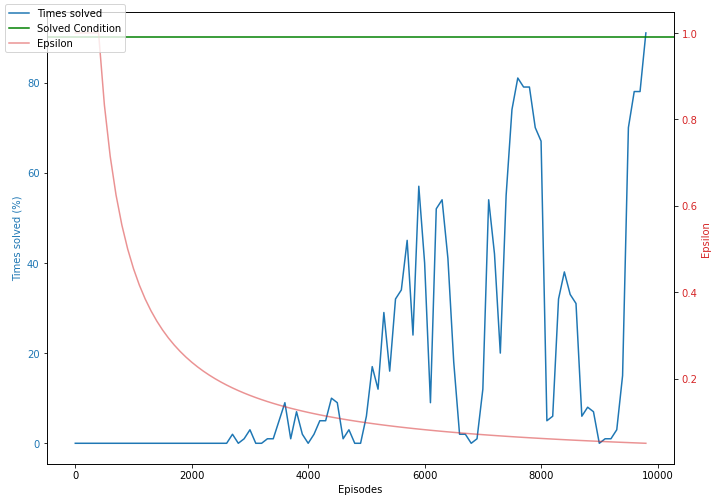

In [8]:
agent.train(episodes=20000, lr=0.01, discount_factor=0.99, problem_solved=90)

Observamos que ha sido capaz de alcanzar el objetivo indicado en menos de 10000 episodios

Realizamos un test para ver como se comportaría nuestro modelo entrenado con 1000 episodios:

In [9]:
agent.test(episodes=1000, render=False)

995 times solved of 1000 episodes


Observamos que resuelve el problema el 99,5% de las veces.

Vamos a visualizar 5 episodios para comprobar que realmente consigue resolverlo:

In [10]:
agent.test(episodes=5, render=True)

5 times solved of 5 episodes


# Mountain Car - DQN

Para la resolución del problema Mountain Car mediante el algoritmo DQN, nos hemos basado con la solúción propuesta en el repositorio de Github: https://github.com/nitish-kalan/MountainCar-v0-Deep-Q-Learning-DQN-Keras

Los principales cambios introducidos respecto al repositorio son los siguientes:
*   En lugar de tenerlo todo separado en diferentes scripts ".py", lo hemos encapsulado todo en la clase "Agent_DQN"
*   Anteriormente se guardaba el modelo con mejor reguard. Sin embargo, se ha comprobado que este modelo no tiene por qué ser el que mejor funciona, de modo que la solución que se ha decidido usar en este caso es: guardar en una carpeta todos los modelos según vayan obteniendo una mejor reward para posteriormente testearlos todos y ver cual es el que realmente nos da un mejor rendimiento.

Importamos las librerias necesarias:

In [11]:
from tensorflow import keras
from keras.layers import Dense, Input
from keras import Model
from collections import deque
import time
import os
import shutil

A continuación creamos la clase principal "Agent_DQN". Estará formada por 6 métodos:

**1) __ init __** : metodo interno que se ejecuta automáticamente cuando se llama a la clase. Inicializa todas las variables. Será neceserario indicar las dimensiones de nuestro entorno como parámetro de entrada.

**2) _create model** : método interno que nos crea el modelo. En este caso será un modelo formado por 2 capas densas de 400 y 300 neuronas respectivamente. Como entrada recibirá el número de observaciones de nuestro entorno (2) y como salidas nos dará la acción predicha a realizar por nuestro agente.

**3) _train_DQN_Agent** : método interno que se encarga de realizar los cálculos necesarios por cada episodio para entrenar el modelo. Este método no era muy necesario pero simplifica el entrenamiento y hace más entendible el código.

**4) train**: método para entrenar el modelo. Parámetros que podemos indicar:
*   **episodes:** número de episodios que llevará a cabo el entrenamiento
*   **batch_size:** tamaño del batch. Número de ejemplos que cogerá aleatoriamente del buffer de memoria
*   **epsilon_decay:** factor de decrecimento de epsilon para cada episodio (inicialmente epsilon=1)
*   **min_epsilon:** valor mínimo que puede tomar epsilon
*   **discount factor:** factor gamma que descuenta recompensas futuras
*   **models_path:** carpeta donde guardará los modelos con mejor reward (Si la carpeta no existe la creará, pero si ya existe la borrará para crearla de nuevo, así evitamos que se nos mezclen modelos de otros entrenamientos anteriores)

**5) test_models**: método para testear todos los modelos guardados. Parámetros que podemos indicar:
*   **episodes:** número de episodios que llevará a cabo en el test
*   **models_path:** Carpeta donde se encuentran los modelos

**6) test_model**: método para testear 1 modelo de todos los que hemos guardado. Parámetros que podemos indicar:
*   **episodes:** número de episodios que llevará a cabo en el test
*   **model_path:** Ruta donde se encuentra el modelo


In [12]:
class Agent_DQN:

    def __init__(self, action_dim, observation_dim):
        
        self.action_dim = action_dim
        self.observation_dim = observation_dim

        self.buffer = deque(maxlen=100_000)
        self.min_buffer_samples = 1000
        self.epsilon = 1
        self.max_reward = -999

        self.model = self._create_model()

    def _create_model(self):
        state_input = Input(shape=(self.observation_dim))
        state_h1 = Dense(400, activation='relu')(state_input)
        state_h2 = Dense(300, activation='relu')(state_h1)
        output = Dense(self.action_dim, activation='linear')(state_h2)
        model = Model(inputs=state_input, outputs=output)
        model.compile(loss='mse', optimizer=keras.optimizers.Adam(0.005))
        return model

    def _train_DQN_Agent(self, batch_size, discount_factor):
        minibatch = random.sample(self.buffer, batch_size)
        X_cur_states = []
        X_next_states = []
        for index, sample in enumerate(minibatch):
            cur_state, action, reward, next_state, done = sample
            X_cur_states.append(cur_state)
            X_next_states.append(next_state)
        
        X_cur_states = np.array(X_cur_states)
        X_next_states = np.array(X_next_states)
        
        # action values for the current_states
        cur_action_values = self.model.predict(X_cur_states)
        # action values for the next_states taken from our agent (Q network)
        next_action_values = self.model.predict(X_next_states)
        for index, sample in enumerate(minibatch):
            cur_state, action, reward, next_state, done = sample
            if not done:
                # Q(st, at) = rt + DISCOUNT * max(Q(s(t+1), a(t+1)))
                cur_action_values[index][action] = reward + discount_factor * np.amax(next_action_values[index])
            else:
                # Q(st, at) = rt
                cur_action_values[index][action] = reward
        # train the agent with new Q values for the states and the actions
        self.model.fit(X_cur_states, cur_action_values, verbose=0)

    def train(self, episodes, batch_size, epsilon_decay, min_epsilon, discount_factor, models_path='saved_models'):
        
        if os.path.exists(models_path):
            shutil.rmtree(models_path)

        os.mkdir(models_path)

        env = gym.make('MountainCar-v0')
        
        for episode in range(episodes):
            starttime = time.time()
            cur_state = env.reset()
            done = False
            episode_reward = 0
            episode_length = 0
            while not done:
                episode_length += 1
                # set VISUALIZATION = True if want to see agent while training. But makes training a bit slower.
                #if VISUALIZATION:
                #    env.render()

                if(np.random.uniform(0, 1) < self.epsilon):
                    # Take random action
                    action = np.random.randint(0, self.action_dim)
                else:
                    # Take action that maximizes the total reward
                    action = np.argmax(self.model.predict(np.expand_dims(cur_state, axis=0))[0])

                next_state, reward, done, _ = env.step(action)

                episode_reward += reward

                if done and episode_length < 200:
                    # If episode is ended the we have won the game. So, give some large positive reward
                    reward = 250 + episode_reward
                    # save the model if we are getting maximum score this time
                    if(episode_reward > self.max_reward):
                        self.model.save_weights(models_path + '/' + str(episode_reward)+"_agent_.h5")
                else:
                    # In oher cases reward will be proportional to the distance that car has travelled 
                    # from it's previous location + velocity of the car
                    reward = 5*abs(next_state[0] - cur_state[0]) + 3*abs(cur_state[1])
                    
                # Add experience to replay memory buffer
                self.buffer.append((cur_state, action, reward, next_state, done))
                cur_state = next_state
                
                if(len(self.buffer) < self.min_buffer_samples):
                    continue
                
                self._train_DQN_Agent(batch_size=batch_size, discount_factor=discount_factor)


            if(self.epsilon > min_epsilon and len(self.buffer) > self.min_buffer_samples):
                self.epsilon *= epsilon_decay

            # some bookkeeping.
            self.max_reward = max(episode_reward, self.max_reward)
            total_time = round((time.time() - starttime), 2)
            print('Episode', episode+1, 'Episodic Reward', episode_reward, 'Maximum Reward', self.max_reward, 'EPSILON', self.epsilon, 'TIME', total_time)

    def test_models(self, episodes, models_path):
        env = gym.make('MountainCar-v0')
        
        for model in os.listdir(models_path):
            directory = models_path + '/' + model
            self.model.load_weights(directory)
            episodes_won = 0

            for _ in range(episodes):
                cur_state = env.reset()
                done = False
                episode_len = 0

                while not done:
                    #env.render()
                    episode_len += 1
                    next_state, reward, done, _ = env.step(np.argmax(self.model.predict(np.expand_dims(cur_state, axis=0))))
                    if done and episode_len < 200:
                        episodes_won += 1
                    cur_state = next_state
            
            print('Model:', model, 'performance -->', episodes_won, '/', episodes, 'EPISODES WON')

        env.close()

    def test_model(self, episodes, model_path):
        env = gym.make('MountainCar-v0')
        self.model.load_weights(model_path)
        episodes_won = 0

        for _ in range(episodes):
            cur_state = env.reset()
            done = False
            episode_len = 0

            while not done:
                env.render()
                episode_len += 1
                next_state, reward, done, _ = env.step(np.argmax(self.model.predict(np.expand_dims(cur_state, axis=0))))
                if done and episode_len < 200:
                    episodes_won += 1
                cur_state = next_state
        
        print(episodes_won, '/', episodes, 'EPISODES WON')
        env.close()
    

Una vez definida la clase, creamos nuestro entrono y calculamos sus dimensiones:

In [13]:
env = gym.make('MountainCar-v0')
action_dim = env.action_space.n
observation_dim = env.observation_space.shape

Definimos nuestro agente:

In [20]:
agent = Agent_DQN(action_dim,observation_dim)

Lo entrenamos: (se observa que el entrenamiento es mucho más lento que utilizando un algoritmo Q learning). Se han realizado pocas pruebas a la hora de modificar hiperparámetros porque el entrenamiento me suponía más de 5 horas. Sin embargo, con estos valores se han podido obtener buenos resultados.

In [21]:
agent.train(episodes = 800, batch_size=32, epsilon_decay=0.99, min_epsilon=0.001, discount_factor=0.99)

Episode 1 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 1 TIME 0.02
Episode 2 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 1 TIME 0.01
Episode 3 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 1 TIME 0.01
Episode 4 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 1 TIME 0.02
Episode 5 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 1 TIME 1.49
Episode 6 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 0.99 TIME 52.9
Episode 7 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 0.9801 TIME 69.14
Episode 8 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 0.9702989999999999 TIME 83.65
Episode 9 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 0.96059601 TIME 83.02
Episode 10 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 0.9509900498999999 TIME 83.03
Episode 11 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 0.9414801494009999 TIME 83.3
Episode 12 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 0.9320653479069899 TIME 85.12
Episode

Comprobamos qué modelo nos da un mejor rendimiento entre todos los que hemos guardado:

In [22]:
agent.test_models(episodes=10, models_path='saved_models')

Model: -109.0_agent_.h5 performance --> 10 / 10 EPISODES WON
Model: -116.0_agent_.h5 performance --> 10 / 10 EPISODES WON
Model: -120.0_agent_.h5 performance --> 0 / 10 EPISODES WON
Model: -127.0_agent_.h5 performance --> 0 / 10 EPISODES WON
Model: -129.0_agent_.h5 performance --> 10 / 10 EPISODES WON
Model: -157.0_agent_.h5 performance --> 0 / 10 EPISODES WON


A continuación visualizamos el funcionamento del mejor modelo en el entorno real (en este caso podríamos elegir cualquiera de los 3 modelos que han sido capaces de resolver los 10 episodios):

In [23]:
agent.test_model(5,model_path='saved_models/-129.0_agent_.h5')

5 / 5 EPISODES WON


# Conclusiones

Observamos que el problema MountainCar se ha podido resolver mediante los 2 métodos. Sin embargo vamos a señalar algunas ventajas e inconvenientes la hora de utilizar un algoritmo de tipo Q-learning respecto a un DQN:

**_Ventajas_**
*   Implementación más sencilla
*   Pocos hiperparámetros
*   Entrenamiento más rápido

**_Desventajas_**
*   Necesidad de discretizar el espacio continuo
*   En entornos más complejos la tabla de valores Q puede tener unas dimensiones extremadamente grandes